## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

2024-08-16 22:34:04.546360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 22:34:04.546494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 22:34:04.681491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the Dataset

In [2]:
train_directory = '/kaggle/input/facial-expression-dataset/train/train/'
test_directory = '/kaggle/input/facial-expression-dataset/test/test/'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
    
    return image_paths, labels
#converts folder structure into a CSV

In [4]:
#convert into dataframe / initialize the dataframe
train = pd.DataFrame() #This line initializes an empty Pandas DataFrame named train. A DataFrame is a two-dimensional, tabular data structure that is used to store and manipulate data in Python.
train['image'], train['label'] = load_dataset(train_directory)

#shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
#The frac parameter specifies the fraction of rows to return. A value of 1 means that all rows will be returned, but in a random order (i.e., shuffled).
#After shuffling, the indices of the rows will be out of order. reset_index resets the index of the DataFrame so that the indices are sequential again.
#drop=True: Ensures that the old index is not added as a new column in the DataFrame
train.head()
#This line displays the first few rows of the DataFrame train. The .head() method by default shows the first 5 rows, allowing you to inspect the contents and verify that the data has been loaded and shuffled correctly.

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/train/...,fear
1,/kaggle/input/facial-expression-dataset/train/...,happy
2,/kaggle/input/facial-expression-dataset/train/...,happy
3,/kaggle/input/facial-expression-dataset/train/...,happy
4,/kaggle/input/facial-expression-dataset/train/...,happy


In [5]:
## convert into dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_directory)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/test/t...,surprise
1,/kaggle/input/facial-expression-dataset/test/t...,surprise
2,/kaggle/input/facial-expression-dataset/test/t...,surprise
3,/kaggle/input/facial-expression-dataset/test/t...,surprise
4,/kaggle/input/facial-expression-dataset/test/t...,surprise


## Data Analysis

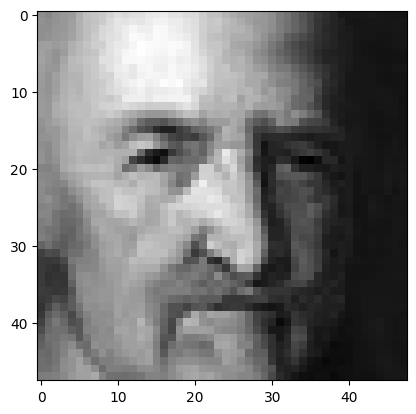

In [6]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

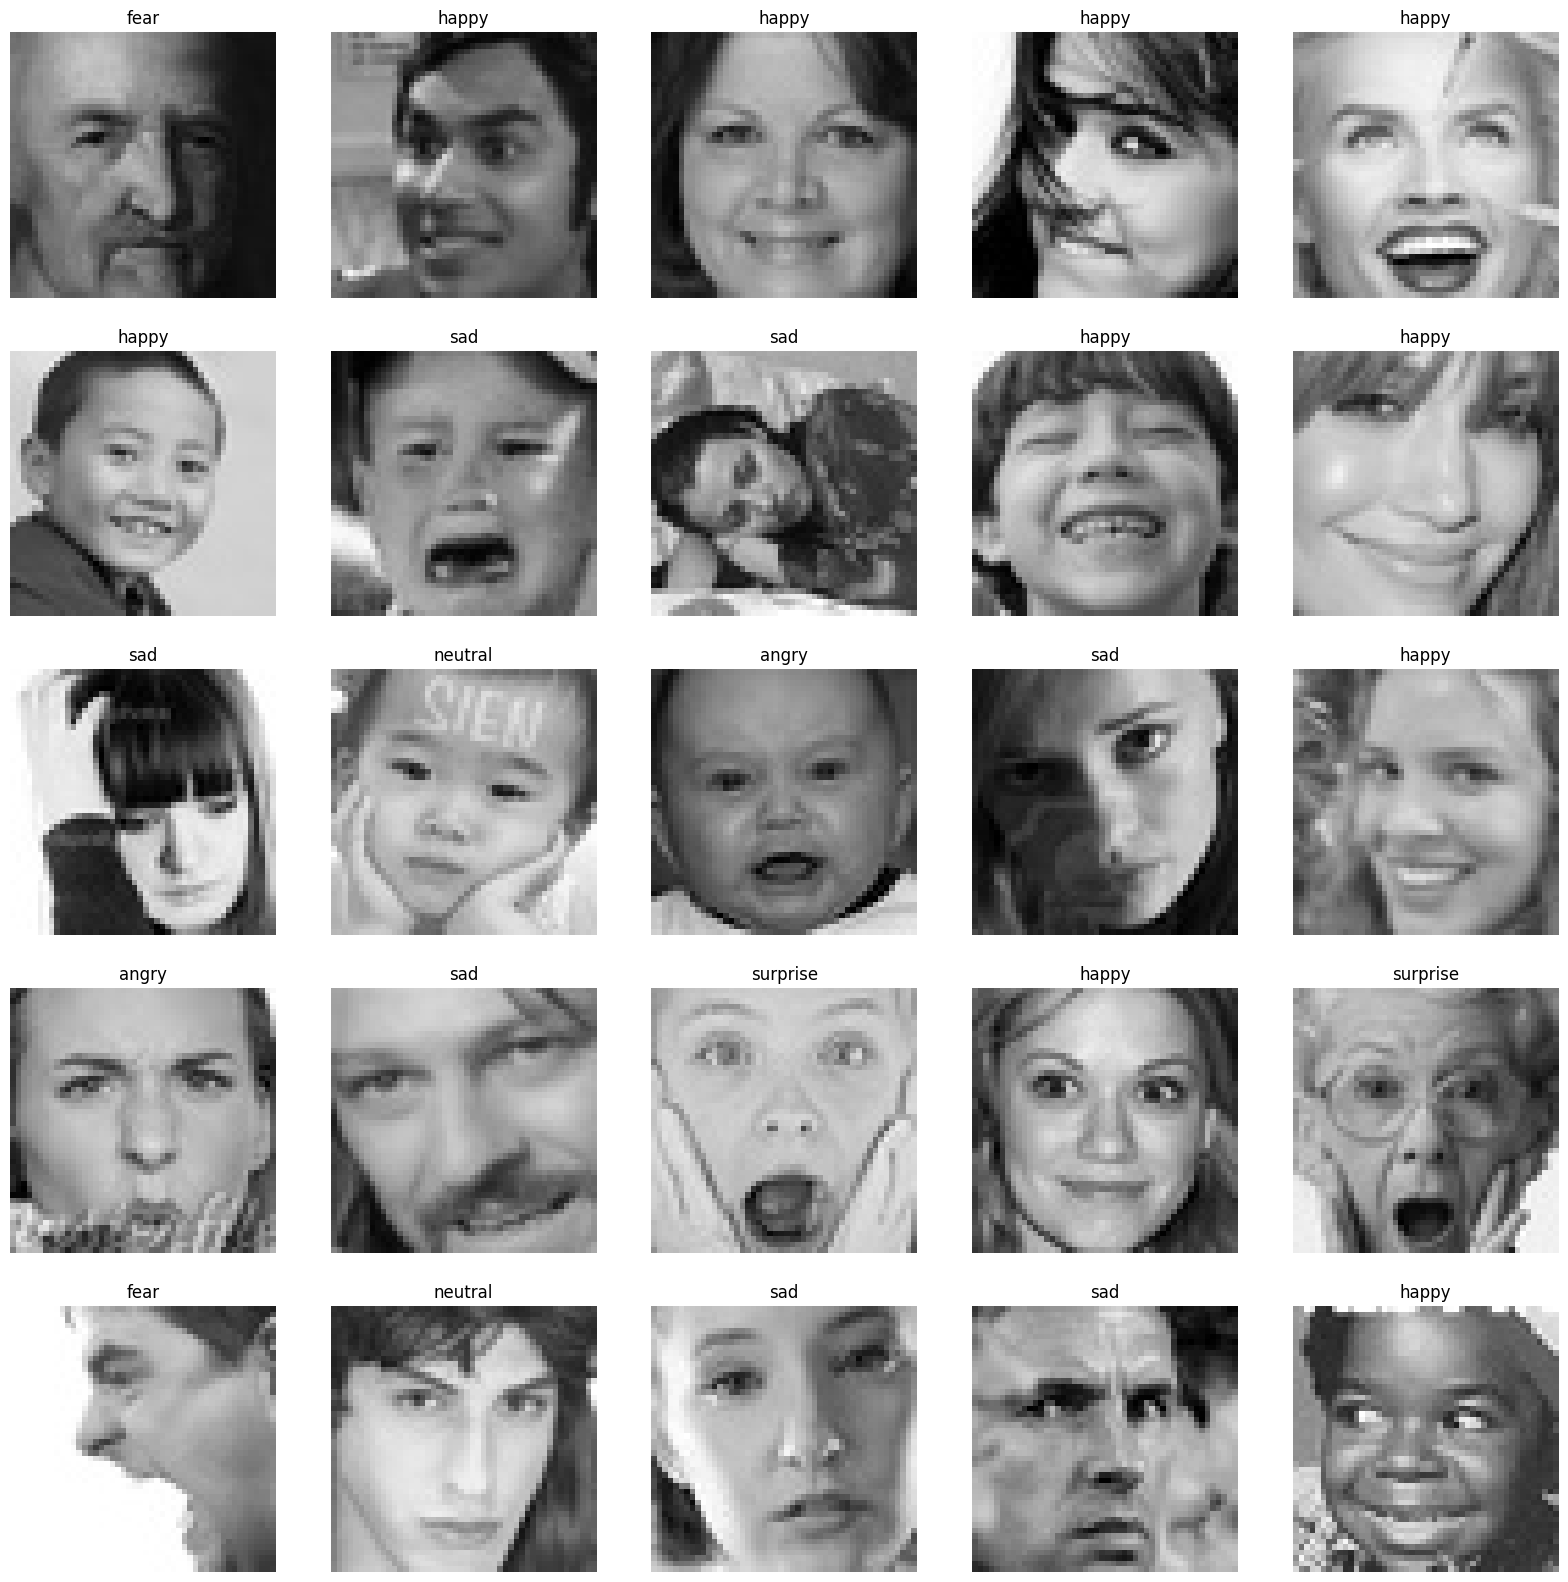

In [7]:
#to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [8]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1) #the 48 48 is for the size of the images as they are 48x48 pixels. The 1 is because it is greyscale, for RGB it'd be 3.
    return features
#Pixel features of the images are extracted
#Images are converted into arrays and reshaped to the proper format
#tqdm creates a loading bar to help track the conversion process of the images

In [9]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [10]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [11]:
##normalise the image, pixel value in between 0 and 1
x_train = train_features/255.0
x_test = test_features/255.0


In [12]:
## convert label to integer (before we see the label is a string e.g. suprised, we want an integer instead)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label']) #transform converts string into integer
y_test = le.transform(test['label'])

In [13]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
#one hot encoding the data - a method of representing characters or words by a vector where only one element is set to one and all others are zero, based on their position in the vocabulary

In [14]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.])

In [15]:
##config
input_shape = (48, 48, 1) #converts the input image into 48 x 48 resolution in grayscale
output_class = 7 #number of labels

## Model Creation

In [16]:
model = Sequential()
#convolutional layers
model.add(Conv2D(128, kernel_size = (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
#fully connected layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
#train the model
history =model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
  7/225 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2032 - loss: 1.9383

I0000 00:00:1723847785.132231      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.2404 - loss: 1.8415 - val_accuracy: 0.2471 - val_loss: 1.8132
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2477 - loss: 1.8147 - val_accuracy: 0.2568 - val_loss: 1.7879
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2709 - loss: 1.7612 - val_accuracy: 0.3378 - val_loss: 1.6484
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3461 - loss: 1.6400 - val_accuracy: 0.4291 - val_loss: 1.4714
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4053 - loss: 1.5308 - val_accuracy: 0.4620 - val_loss: 1.3836
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4401 - loss: 1.4471 - val_accuracy: 0.4886 - val_loss: 1.3293
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4619 - loss: 1.3984 - val_accuracy: 0.4954 - val_loss: 1.3060
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4784 - loss: 1.3625 - val_accurac

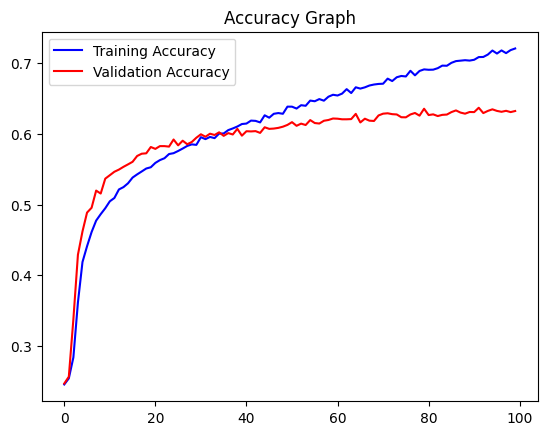

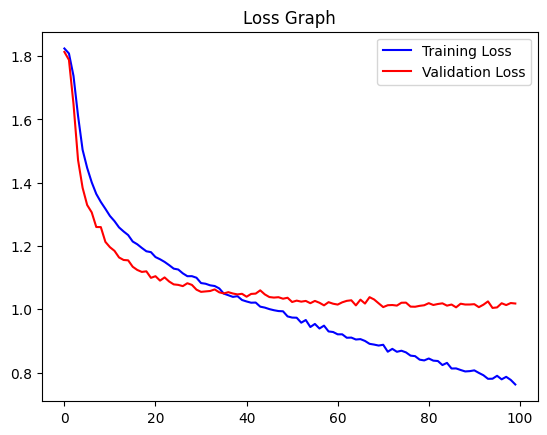

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
Predicted Output: fear


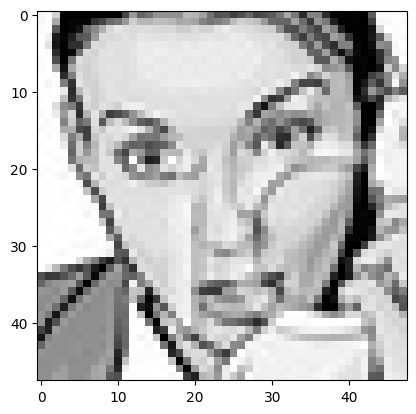

In [19]:
#display a few random images with its label and predict the output
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Output: fear


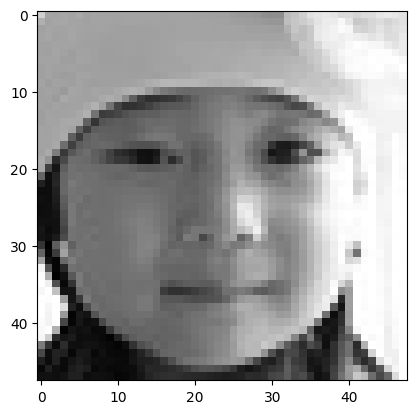

In [20]:
#display a few random images with its label and predict the output
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Output: fear


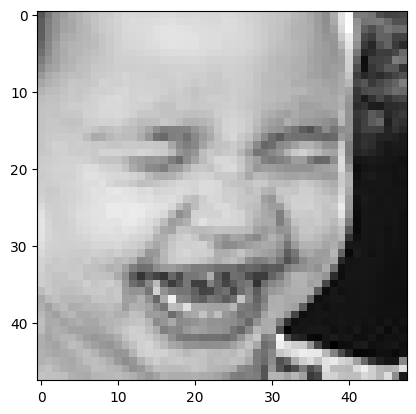

In [21]:
#display a few random images with its label and predict the output
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');